# AI content detector | LSTM based Deep learning network

### Importing required packages

In [75]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score


### Data Cleaning

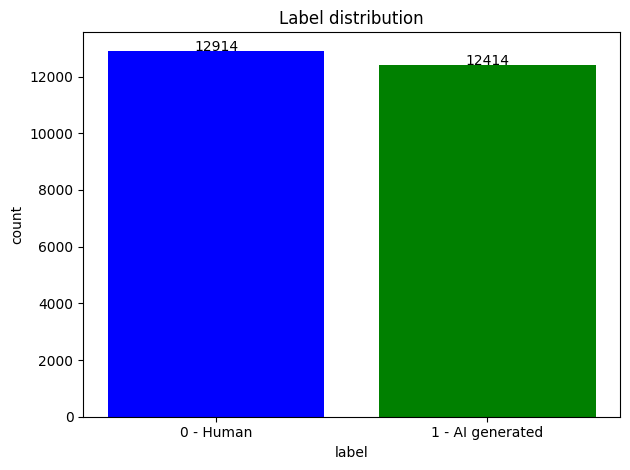

In [72]:
train_data = pd.read_csv("train_drcat_02.csv")
train_data.drop(columns=["essay_id", "source", "prompt", "fold"], inplace=True)

major_class = train_data[train_data["label"] == 0]
minor_class = train_data[train_data["label"] == 1]
major_class_downsampled = resample(
    major_class,
    replace=False,
    n_samples=len(minor_class) + 500,
    random_state=42,
)
train_df = pd.concat([major_class_downsampled, minor_class])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

fig, ax = plt.subplots()
ax.bar(
    ["0 - Human", "1 - AI generated"],
    train_df.label.value_counts(),
    color=["blue", "green"],
)
for i in ax.patches:
    ax.text(
        i.get_x() + i.get_width() / 2,
        i.get_height(),
        str(int(i.get_height())),
        ha="center",
    )
plt.title("Label distribution")
plt.ylabel("count")
plt.xlabel("label")
plt.tight_layout()
plt.show()


### Transforming data for Tensorflow (tensors) to train the LSTM

In [17]:
def create_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["text"], df["label"]))
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.batch(256).cache().prefetch(tf.data.AUTOTUNE)
    return dataset


### Splitting dataset in training/test sets

In [13]:
train_data, valid_data = train_test_split(
    train_df, test_size=0.2, stratify=train_df["label"], random_state=42
)
print(
    "Train data size :      ",
    train_data.shape,
    "\nValidation data size : ",
    valid_data.shape,
)

train_dataset = create_dataset(train_data)
valid_dataset = create_dataset(valid_data)


Train data size :       (20262, 2) 
Validation data size :  (5066, 2)


### Text Vectorization layer
> Some metrics to remember :
- Total unique words in dataset = 120861
- Max length of input sequence = 1656

In [28]:
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=50000,
    output_sequence_length=1500,
    pad_to_max_tokens=True,
)
vectorizer.adapt(train_df["text"], batch_size=1500)


### Defining the Bi-directional LSTM NN
*Model Summary & Flowchart at the end*

Model: "Bi-directional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, 1500)              0         
 Vectorization)                                                  
                                                                 
 embedding_7 (Embedding)     (None, 1500, 64)          3200000   
                                                                 
 bidirectional_14 (Bidirect  (None, 1500, 128)         66048     
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_14 (Dense)            (None, 16)                1040      
                                               

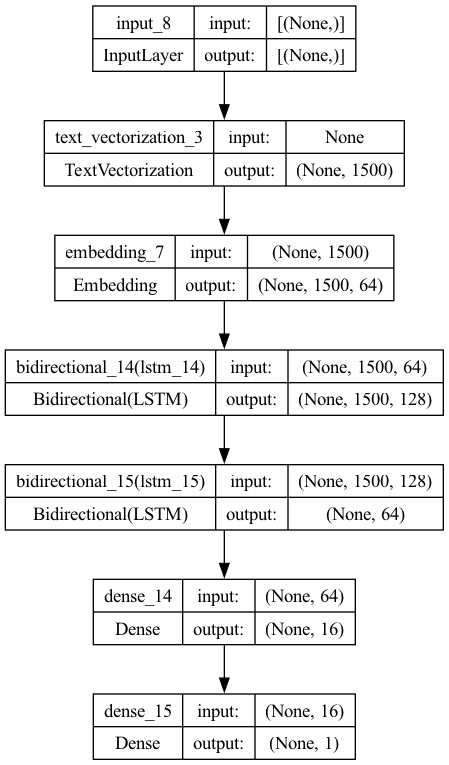

In [31]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(), dtype=tf.string),
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=50000,
            output_dim=64,
            input_length=1500,
            mask_zero=True,
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="Bi-directional_LSTM",
)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)


### Model Training
`IF WEIGHTS FOUND: load weights; ELSE: retrain model`

In [32]:
weights_path = "weights/weights.tf"
plot_learning_graphs = False

if not os.path.exists("weights/"):
    plot_learning_graphs = True
    history = model.fit(
        train_dataset,
        epochs=10,
        validation_data=valid_dataset,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                filepath=weights_path,
                save_weights_only=True,
                save_best_only=True,
                monitor="val_accuracy",
                mode="max",
            )
        ],
    )
else:
    model.load_weights(weights_path)


Epoch 1/10


2024-04-24 22:44:03.351402: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


80/80 [==============================] - 784s 10s/step - loss: 0.1729 - accuracy: 0.9251 - auc: 0.9807 - val_loss: 0.0744 - val_accuracy: 0.9777 - val_auc: 0.9957
Epoch 2/10
80/80 [==============================] - 740s 9s/step - loss: 0.0592 - accuracy: 0.9804 - auc: 0.9965 - val_loss: 0.0769 - val_accuracy: 0.9745 - val_auc: 0.9970
Epoch 3/10
80/80 [==============================] - 737s 9s/step - loss: 0.0526 - accuracy: 0.9824 - auc: 0.9974 - val_loss: 0.0546 - val_accuracy: 0.9826 - val_auc: 0.9967
Epoch 4/10
80/80 [==============================] - 747s 9s/step - loss: 0.0311 - accuracy: 0.9903 - auc: 0.9986 - val_loss: 0.0495 - val_accuracy: 0.9852 - val_auc: 0.9966
Epoch 5/10
80/80 [==============================] - 714s 9s/step - loss: 0.0241 - accuracy: 0.9922 - auc: 0.9992 - val_loss: 0.0460 - val_accuracy: 0.9870 - val_auc: 0.9966
Epoch 6/10
80/80 [==============================] - 712s 9s/step - loss: 0.0140 - accuracy: 0.9956 - auc: 0.9996 - val_loss: 0.0438 - val_accurac

### Learning Curve

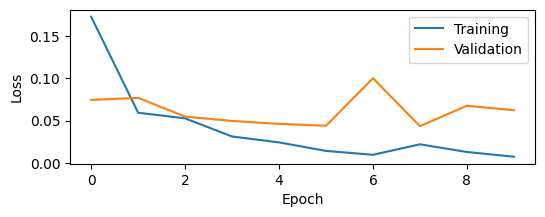

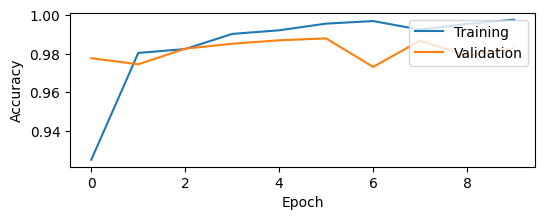

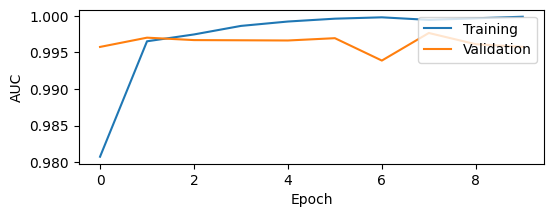

In [73]:
if plot_learning_graphs:
    plt.figure(figsize=(6, 2))
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="upper right")

    plt.figure(figsize=(6, 2))
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="upper right")

    plt.figure(figsize=(6, 2))
    plt.plot(history.history["auc"])
    plt.plot(history.history["val_auc"])
    plt.ylabel("AUC")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="upper right")
    plt.show()

plot_learning_graphs = False


### Model Evaluation

In [34]:
val_loss, val_accuracy, val_auc = model.evaluate(valid_dataset)
print(f"Validation Loss: {val_loss: .4f}")
print(f"Validation Accuracy: {val_accuracy: .4f}")
print(f"Validation AUC: {val_auc: .4f}")


20/20 [==============================] - 57s 3s/step - loss: 0.0622 - accuracy: 0.9828 - auc: 0.9957
Validation Loss:  0.0622
Validation Accuracy:  0.9828
Validation AUC:  0.9957


### Testing Classifier
- POSITIVE CLASS = 1 (LLM generated)

In [78]:
test = pd.read_csv("testset.csv")
test["predicted"] = model.predict(test["text"])
test["predicted"] = test["predicted"].round()


44/44 [==============================] - 12s 267ms/step


### Model Evaluation
- Confusion Matrix
- ROC Curve

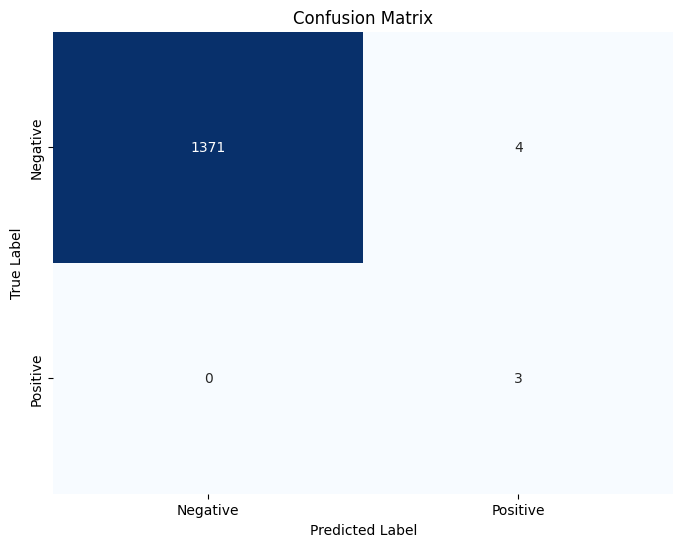

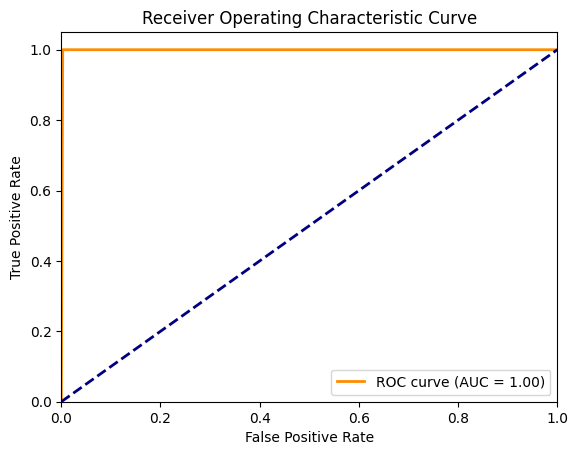

In [79]:
# Creating Confusion Matrix
conf_matrix = confusion_matrix(test["label"], test["predicted"])
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(test["label"], test["predicted"])
roc_auc = roc_auc_score(test["label"], test["predicted"])

# Ploting ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()


### Custom Testing on Classifier

In [123]:
gpt_text = pd.DataFrame(
    data={
        "text": [
            """ChatGPT is a large language model developed by OpenAI. It is trained on a massive dataset of
                text and is able to generate human-like responses to a wide range of prompts. It can be used for
                a variety of tasks such as language translation, text summarization, and conversation generation.
                It has been trained on a diverse set of internet text and is capable of understanding and generating
                text in a variety of languages and styles.""",
            """Emile Durkheim’s theories on collective effervescence and social solidarity can be used to explain what
                happens at a sporting event in the United States. Collective effervescence refers to the emotional excitement
                and energy that is generated when people come together in a group, and this can be seen at a sporting event
                as fans come together to support their team. This shared enthusiasm creates a sense of unity and belonging
                among the fans, and can lead to a heightened sense of social solidarity. This solidarity is strengthened by the
                shared emotions, values and beliefs of the fans, and the shared goal of supporting their team to victory.""",
            """We will curate a number of data sets and prompts/problems to solve, and you will apply
                machine learning techniques towards solving that problem. You will write up a report of
                what choices you made (how you engineered features, how you chose the model you used,
                what success metrics were appropriate, etc.). You may also propose your own data set and
                model design if you wish. Email us a link to the data and what you’re proposing to do and
                we’ll approve as appropriate.""",
            """Whichever option you choose, you must both write code that implements a model and
                write a few pages answering the questions described above. If you work in a group,
                please be prepared to document the contribution of each teammate.
                • You may collaborate in groups of two or three. The code and writing you turn in must
                be your writing and your code. If you turn in code that you found in a public GitHub
                repo or wasn’t written by you or if you plagiarize your writing, then this will be treated
                as a case of academic dishonesty and you will fail this course.
                • Ideally, you should have a project chosen by Monday, March 18 (i.e. you should know
                what you’re doing when you come back from Spring Break.)
                • There will be a progress report due on April 10. All this entails is a couple of paragraphs
                describing what you have accomplished and implemented so far. This won’t be graded,
                but we will be in touch with you if you don’t turn it in.
                • All projects are due at midnight on April 26 (Thursday night).
                • Please don’t wait until April 23 to start this. This project is worth 40% of your grade,
                so please spend a commensurate amount of effort on it.
                • All project ideas are subject to approval (unless you use one of the instructor-curated
                data sets and promps), so don’t wait too long to propose something as it might require
                some time for us to discuss and get back to you.""",
        ]
    }
)

y_pred = model.predict(gpt_text["text"]).round()
print()
for res in y_pred:
    print("AI") if res >= 0.01 else print("Human")


1/1 [==============================] - 0s 140ms/step

AI
AI
Human
Human


In [127]:
while True:
    input_txt = input("Enter text :")
    if input_txt.lower() in ["", "n", "no"]:
        break
    text = pd.DataFrame(data={"text": [input_txt]})
    res = model.predict(text["text"])
    (
        print("Text :\t", input_txt, "\nText generated by AI, Likeliness = ", res[0][0])
        if (res[0][0] >= 0.01)
        else print("Text :\t", input_txt, "\nText written by Human, Likeliness = ", res[0][0])
    )
    print()


1/1 [==============================] - 0s 114ms/step
Text :	 Exceptions to this policy for medical reasons will only be granted with the permission of the Associate Chair of the Computer Science department. Please direct requests for medical exceptions to this late policy, and supporting documentation, to the Associate Chair 
Text written by Human, Likeliness =  0.00086521765

1/1 [==============================] - 0s 98ms/step
Text :	 Artificial intelligence (AI) has the capability to assist in the creation of blog entries covering a wide range of subjects, including marketing, technology, health, lifestyle, and more. Authors have the ability to utilize artificial intelligence (AI) in order to obtain ideas, derive inspiration, and even generate initial drafts for their blog posts. Subsequently, individuals has the ability to modify, enhance, or refine the substance in accordance with their preferred manner of expression, linguistic quality, and target readership. This blog article dis